<a href="https://colab.research.google.com/github/dinesh-umkc/kdm/blob/main/ICP_8_Yelp_Review_Classification_with_LSTM_RNN_and_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [27]:
from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.models import Sequential
from keras.layers import Embedding, Conv1D,MaxPooling1D, Flatten, Dense,Dropout,LSTM,Bidirectional, CuDNNLSTM
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report #
import scikitplot as skplt #


ImportError: ignored

### Load Data

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Projects/Data/yelp_academic_dataset_review_1M.csv')

In [6]:
data.head()

,review_id,user_id,cool,text,business_id,stars,date,funny,useful
0,b'Suur9K3VyARIJEdYNLlajg',b'K8D22KUbpfCxvK91lt5sxw',0,"b""I'm addicted! Love choosing my own toppings...",b'DU2KrvS9kBBV-HwzE2fQrA',5.0,b'2017-02-06 13:50:41',0,1
1,b'y3Fo8hd5KH7H63lX3T-zVA',b'XQpnAMe8uluv63TrDR5CgQ',0,"b""Our issue is something that unfortunately se...",b'1fy9fS3UH2k4TfQcryNKkA',1.0,b'2016-12-16 16:34:41',0,5
2,b'yTKU-LrQeThd7qldY3ZIiw',b'76_fiFy4Q3ao46WVSrKByg',0,b'All about the location. What a great spot. E...,b'Un-UDVOuv1co3TMmGaumxA',4.0,b'2018-05-05 21:25:49',0,0
3,b'ftrOgQ68B1dJvDDMIDcpIw',b'9p-deRHVfTM12virS2oP7w',0,"b""The staff was so nice. You can't find a pla...",b'5dtNc-kauiPwdrLNZbCqvg',2.0,b'2015-01-29 19:19:42',0,2
4,b'u7RW2ke8d0FUnooLbFcP8g',b'_A8HDRZBBWIB5d7zLtezbQ',0,b'We have Marcus and Amenda for our company Fa...,b'0IjDqJexP6jTH4F_Kg4mrQ',5.0,b'2012-08-21 20:54:03',0,0


In [7]:
def simple_stars(stars): 
  if stars>3:
    return 1
  else:
    return 0

In [8]:
data['stars_binary'] = data['stars'].map(simple_stars)

In [9]:
data = data.dropna()
text = data['text'].tolist()
# binstars = data['stars'].tolist()
binstars = data['stars_binary'].tolist()

binstars = [int(star) for star in binstars]

### Make a balanced dataset of positive and negative review -- 50:50

In [10]:
df_pos = data[data['stars_binary'] == 1].sample(25000, random_state = 5560)
df_neg = data[data['stars_binary'] == 0].sample(25000, random_state = 5560)
df_balanced = pd.concat([df_pos, df_neg]).reset_index(drop=True)
df_balanced.head()

,review_id,user_id,cool,text,business_id,stars,date,funny,useful,stars_binary
0,b'rdutMrXH5QOkayDBBLmQyQ',b'bmbJ-uH0bmr2SV73TKEwyw',0,"b""My go to for a Philly cheesesteak. Steak wit...",b'RQAF6a0akMiot5lZZnMNNw',4.0,b'2022-01-11 21:24:20',1,1,1
1,b'F0IvWLU3xozOeTgw8_nzqw',b'LLqno28QBXZAxO94PMGSzw',0,b'This is a story of welcome rediscovery. My ...,b'_9Z3cuZQBOGv_XzSG4ewHA',4.0,b'2015-02-09 04:23:21',0,3,1
2,b'_IcuqvMS_m-2dcdFpLqfpQ',b'5MYa3BbBU359oqcEYwY94w',1,b'Food is pretty good but my boyfriend and I l...,b'ZTjEoBreuWsPx_q-k1Llvg',4.0,b'2014-03-02 22:36:48',0,0,1
3,b'F6U5H6CoVjH2LNpAJhsU3Q',b'rMaiCxwiOYAwtLk3UsH2cA',0,b'Outstanding food and great service staff was...,b'OM5beWRkxZSu1TShUC3EDw',5.0,b'2020-01-16 04:41:11',0,2,1
4,b'Q0S-CfhQAcQPlh8TehYn9w',b'AQGMTHae70n3MnONotAuYQ',4,b'21C is the tits!\n\nDisclaimer: I did not st...,b'P2UDTyHD4KX6OpzYlH3TZw',5.0,b'2018-10-14 21:05:45',0,3,1


In [11]:
X = df_balanced['text'].values
y = df_balanced['stars_binary'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5560)

In [12]:
# cut reviews after 200 words
maxlen = 200 
# Number of words to consider as features
# restrict the yelp reviews to the top 10000 most common words
max_words = 10000  

In [43]:
# create a tokenizer and it will ignore all except the 10000 most-common words
tokenizer = Tokenizer(num_words = max_words)
# use tokenizer to calculate the frequency of each word in dataset.
# tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X)

# convert all of reviews to lists of integers
# sequences = tokenizer.texts_to_sequences(balanced_texts)
# integer encode the documents
encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_test = tokenizer.texts_to_sequences(X_test)
print(encoded_train[0:2])

# use pad_sequence to make traning samples the same size, fill with zeros
# data_input = pad_sequences(sequences, maxlen = maxlen)
padded_train = pad_sequences(encoded_train, maxlen=maxlen)
padded_test = pad_sequences(encoded_test, maxlen=maxlen)

[[736, 87, 250, 58, 676, 2796, 2, 4, 3415, 2691, 2796, 2, 179, 6, 44, 14, 87, 991, 9, 146, 39, 40, 84, 6, 20, 45, 2, 226, 37], [527, 641, 121, 7342, 2379, 34, 1, 361, 6, 38, 358, 2, 3081, 5, 70, 89, 108, 37]]


In [45]:
padded_train

array([[   0,    0,    0, ...,    2,  226,   37],
       [   0,    0,    0, ...,   89,  108,   37],
       [   0,    0,    0, ...,  373,  168,   69],
       ...,
       [   0,    0,    0, ...,  224, 4733,   16],
       [   0,    0,    0, ...,  785,  447,   37],
       [  18,    8,  541, ..., 9872,   10, 1693]], dtype=int32)

In [46]:
y_train

array([[1.],
       [0.],
       [1.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

 ### Model 1 - Using Embedding layer and LSTM

My first model consisted of an embedding layer, a LSTM layer and the output from LSTM was fed into a hidden fully connected layer. This layer has an output size of 1, meaning it will always output 1 or 0, 1 for positive reviews and 0 for negative ones.

The requirements to use the cuDNN implementation are:
```python
activation == tanh
recurrent_activation == sigmoid
recurrent_dropout == 0
unroll is False
use_bias is True
Inputs, if use masking, are strictly right-padded.
Eager execution is enabled in the outermost context.
```

In [14]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [15]:
max_words = 10000 
maxlen = 200
model = Sequential()
model.add(Embedding(max_words, 64,input_length = maxlen))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 64)           640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 673,089
Trainable params: 673,089
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(padded_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 14s 30ms/step - loss: 0.3886 - acc: 0.8316 - val_loss: 0.3062 - val_acc: 0.8742
Epoch 2/5
250/250 [==============================] - 4s 16ms/step - loss: 0.2583 - acc: 0.9018 - val_loss: 0.2705 - val_acc: 0.8878
Epoch 3/5
250/250 [==============================] - 7s 28ms/step - loss: 0.2252 - acc: 0.9135 - val_loss: 0.2627 - val_acc: 0.8901
Epoch 4/5
250/250 [==============================] - 4s 17ms/step - loss: 0.2035 - acc: 0.9229 - val_loss: 0.2670 - val_acc: 0.8914
Epoch 5/5
250/250 [==============================] - 4s 17ms/step - loss: 0.1898 - acc: 0.9284 - val_loss: 0.2734 - val_acc: 0.8906


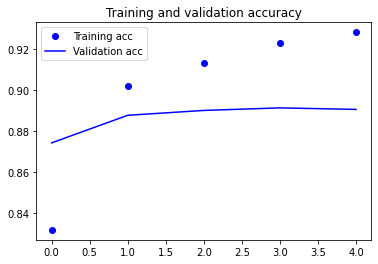

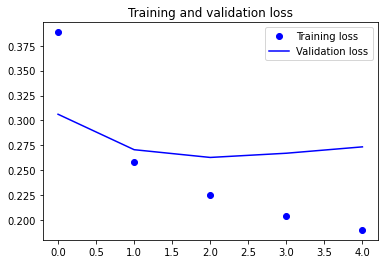

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [18]:
model.evaluate(padded_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.2570 - acc: 0.8982


[0.2569575309753418, 0.8981999754905701]

In [19]:
predictions = {}
y_preds = (model.predict(padded_test) > 0.5).astype("int32")
print(y_preds)
accuracy_LSTM = accuracy_score(y_test, y_preds)

predictions['LSTM_Only'] = accuracy_LSTM * 100


313/313 [==============================] - 2s 4ms/step
[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


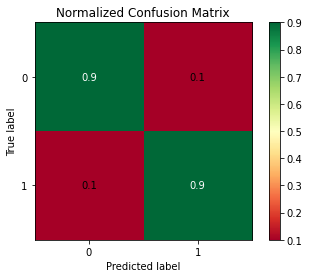

In [20]:
skplt.metrics.plot_confusion_matrix(y_test, y_preds, normalize = True, cmap = 'RdYlGn')

This paper (https://arxiv.org/pdf/1903.07288.pdf) studied the effect of padding types on LSTM and CNN. They found that post-padding achieved substantially lower accuracy (nearly half) compared to pre-padding in LSTMs, although there wasn't a significant difference for CNNs (post-padding was only slightly worse).

A simple/intuitive explanation for RNNs is that, post-padding seems to add noise to what has been learned from the sequence through time, and there aren't more timesteps for the RNN to recover from this noise. With pre-padding, however, the RNN is better able to adjust to the added noise of zeros at the beginning as it learns from the sequence through time.

 ### Model 2 -  Using combination of CNN and RNN

 For my second model, I used combination of recurrent neural network with LSTM and convolutional neural network. I had a dropout layer right after embedding layer and added a convolutional layer, a max pooling layer.


In [21]:
model_conv = Sequential()
model_conv.add(Embedding(max_words, 128, input_length=maxlen))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=3))
model_conv.add(LSTM(64))
model_conv.add(Dense(1, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 dropout (Dropout)           (None, 200, 128)          0         
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 65, 64)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [22]:
history = model_conv.fit(padded_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 9s 14ms/step - loss: 0.3573 - acc: 0.8386 - val_loss: 0.2634 - val_acc: 0.8929
Epoch 2/5
250/250 [==============================] - 3s 12ms/step - loss: 0.2169 - acc: 0.9188 - val_loss: 0.2559 - val_acc: 0.8957
Epoch 3/5
250/250 [==============================] - 3s 12ms/step - loss: 0.1641 - acc: 0.9399 - val_loss: 0.2723 - val_acc: 0.8888
Epoch 4/5
250/250 [==============================] - 3s 12ms/step - loss: 0.1197 - acc: 0.9575 - val_loss: 0.3125 - val_acc: 0.8841
Epoch 5/5
250/250 [==============================] - 3s 12ms/step - loss: 0.0831 - acc: 0.9724 - val_loss: 0.3848 - val_acc: 0.8806


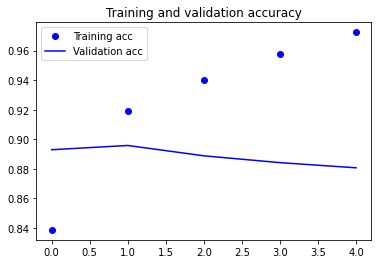

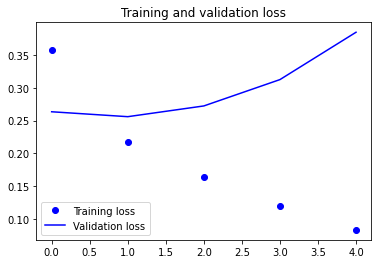

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [24]:
model_conv.evaluate(padded_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.3807 - acc: 0.8863


[0.38074371218681335, 0.8863000273704529]

In [25]:
y_preds = (model_conv.predict(padded_test) > 0.5).astype("int32")
print(y_preds)
accuracy_LSTM_CNN = accuracy_score(y_test, y_preds)

predictions['LSTM_CNN'] = accuracy_LSTM_CNN * 100

313/313 [==============================] - 1s 3ms/step
[[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [1]]


Compare this with model using a LSTM layer only, the accuracy was lower, 89.592% vs 88.28%. The model was overfitting after one epoch. However, adding a convolutional layer did speed up the training

CNN overfits the training data fairly quickly, leading to lower performance in validation/test data.

#Assignment #1:  Use bidirectional RNNs
Bidirectional LSTM (BiLSTM) is a recurrent neural network used primarily on natural language processing. Unlike standard LSTM, the input flows in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

* Wrap the `Bidirectional` Layer around the `LSTM` layer to create a BiLSTM layer
* Train and report accuracy

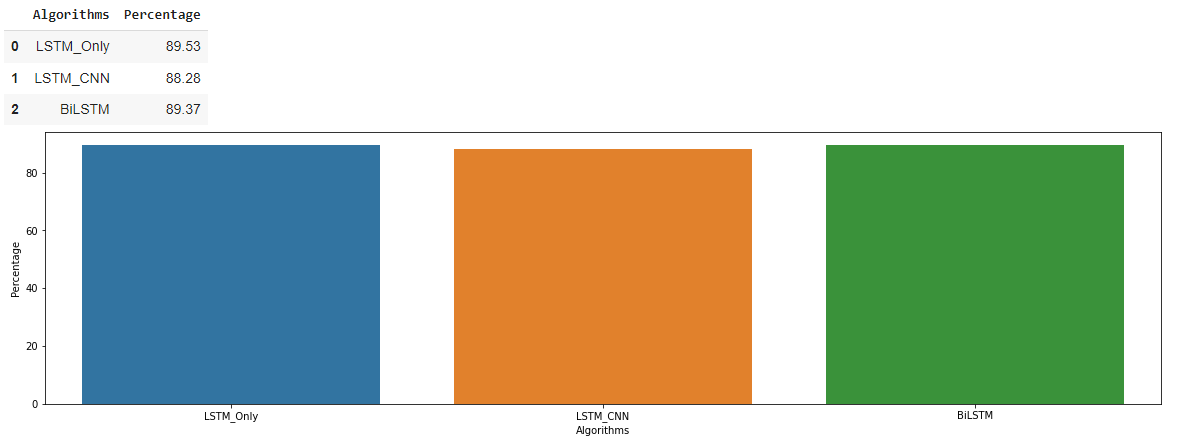


In [31]:
from keras import backend as K
K.clear_session()

In [48]:
#Define and Compile your model architecture here
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, 128, input_length=maxlen))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          1280000   
                                                                 
 dropout_1 (Dropout)         (None, 200, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 200, 128)         98816     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 200, 1)            129       
                                                                 
Total params: 1,378,945
Trainable params: 1,378,945
Non-trainable params: 0
_________________________________________________________________


In [47]:
#Train your model here
history = model_bilstm.fit(padded_train, y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/5


TypeError: ignored

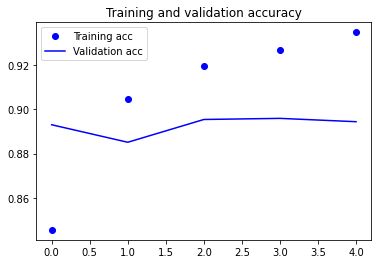

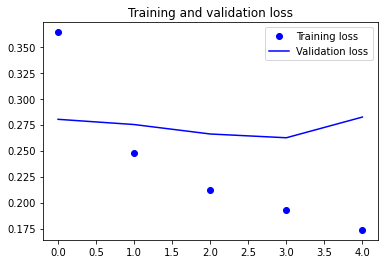

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.evaluate(...)

313/313 [==============================] - 5s 14ms/step - loss: 0.2758 - acc: 0.8937


[0.2758282721042633, 0.8937000036239624]

In [ ]:
y_preds = (model.predict(padded_test) > 0.5).astype("int32")
print(y_preds)
accuracy_BiLSTM = accuracy_score(y_test, y_preds)

predictions['BiLSTM'] = accuracy_BiLSTM * 100

[[0]
 [1]
 [0]
 ...
 [0]
 [0]
 [1]]


,Algorithms,Percentage
0,LSTM_Only,89.53
1,LSTM_CNN,88.28
2,BiLSTM,89.37


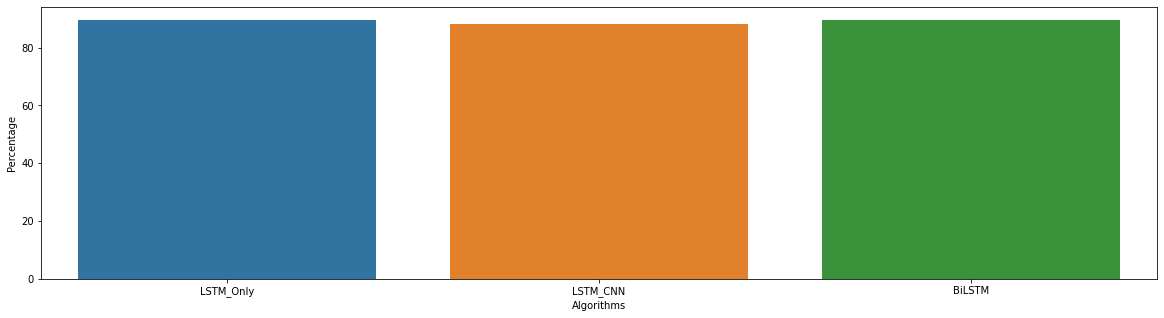

In [ ]:
import seaborn as sns
fig, (ax1) = plt.subplots(ncols = 1, sharey = True,figsize = (20,5))
df = pd.DataFrame(list(predictions.items()),columns = ['Algorithms','Percentage'])
display(df)
sns.barplot(x = "Algorithms", y = "Percentage", data = df,ax = ax1);

# Assignment #2: Use original labels instead of binary labels.

* Use `stars` instead of `stars_binary` for classification and report accuracy.
* Use another version of the dataset (`1M.csv` or full dataset).